In [1]:
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD

import tensorflow as tf


In [2]:
plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train[0].shape, "\n")
img_rows, img_cols, channels = 28, 28, 1 # 32, 32, 3
num_classes = 10

X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.reshape((-1, img_rows, img_cols, channels))
X_test = X_test.reshape((-1, img_rows, img_cols, channels))

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

(28, 28) 



In [4]:
(X_train_C, y_train_C), (X_test_C, y_test_C) = cifar10.load_data()

img_cols_C, img_rows_C, channels_C = 32, 32, 3
num_classes_C = 10

X_train_C = X_train_C / 255
X_test_C = X_test_C / 255

X_train_C = X_train_C.reshape((-1, img_rows_C, img_cols_C, channels_C))
X_test_C = X_test_C.reshape((-1, img_rows_C, img_cols_C, channels_C))

y_train_C = to_categorical(y_train_C, num_classes_C)
y_test_C = to_categorical(y_test_C, num_classes_C)

labels_C = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [5]:
jfile = open("../CNN_model_cifar.json", "r")
loaded_json1 = jfile.read()
jfile.close()
# with CustomObjectScope({'HeUniform': he_uniform()}):
loaded_model1 = model_from_json(loaded_json1)
loaded_model1.load_weights("../CNN_model_cifar.h5")
loaded_model1.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss="categorical_crossentropy", metrics=['accuracy'])

loaded_model1.summary()

Model: "CNN_model_cifar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)    

In [6]:
predictions = loaded_model1.predict(X_test_C)
print(labels[loaded_model1.predict(X_test_C[2].reshape((1, img_rows_C, img_cols_C, channels_C))).argmax()])
pred = list()
for i in range(len(predictions)):
    pred.append(np.argmax(predictions[i]))

test = list()
for i in range(len(y_test_C)):
    test.append(np.argmax(y_test_C[i]))

evaluation = loaded_model1.evaluate(X_test_C, y_test_C)
print(pred, "\n", test)

print("\n%s: %.2f%%" % (loaded_model1.metrics_names[1], evaluation[1]*100))

eight
313/313 [==============================] - 15s 47ms/step - loss: 0.4209 - accuracy: 0.8609

In [7]:
jfile = open("../CNN_model_mnist.json", "r")
loaded_json = jfile.read()
jfile.close()
loaded_model = model_from_json(loaded_json)
loaded_model.load_weights("../CNN_model_mnist.h5")
loaded_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

jfile = open("../CNN_model_mnist_adversarial.json", "r")
loaded_json_adv = jfile.read()
jfile.close()
loaded_model_adv = model_from_json(loaded_json_adv)
loaded_model_adv.load_weights("../CNN_model_mnist_adversarial.h5")
loaded_model_adv.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [8]:
predictions = loaded_model.predict(X_test)
print(labels[loaded_model.predict(X_test[2].reshape((1, img_rows, img_cols, channels))).argmax()])
pred = list()
for i in range(len(predictions)):
    pred.append(np.argmax(predictions[i]))

test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

evaluation = loaded_model.evaluate(X_test, y_test)
print(pred, "\n", test)

print("\n%s: %.2f%%" % (loaded_model.metrics_names[1], evaluation[1]*100))

one
313/313 [==============================] - 1s 2ms/step - loss: 0.0033 - accuracy: 0.9790  

## Basic-Iterative method - BIM

In [9]:
def get_logits(model):
    model.layers[-1].activation = None

def adversarial_patternBIM(input_image, label, alpha, eps, max_iter, model):
    input_image = tf.cast(input_image, tf.float32)
    get_logits(model)

    for _ in tf.range(max_iter):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(input_image)
            logits = model(input_image)
            loss = tf.compat.v1.losses.softmax_cross_entropy(label, tf.reshape(logits, (-1,)))

        gradient = tape.gradient(loss, input_image)

        perturbations = alpha * tf.sign(gradient)

        adv_img = input_image + perturbations

        adv_img = tf.clip_by_value(adv_img, input_image - eps, input_image + eps)
        adv_img = tf.clip_by_value(adv_img, 0, 1)

    return adv_img, np.array(perturbations)


In [10]:
image = X_train[65].reshape((1, img_rows, img_cols, channels))
true_label = y_train[65]

adv, pert = adversarial_patternBIM(image, true_label, 4., 0.2, 50, loaded_model)

Original image: five


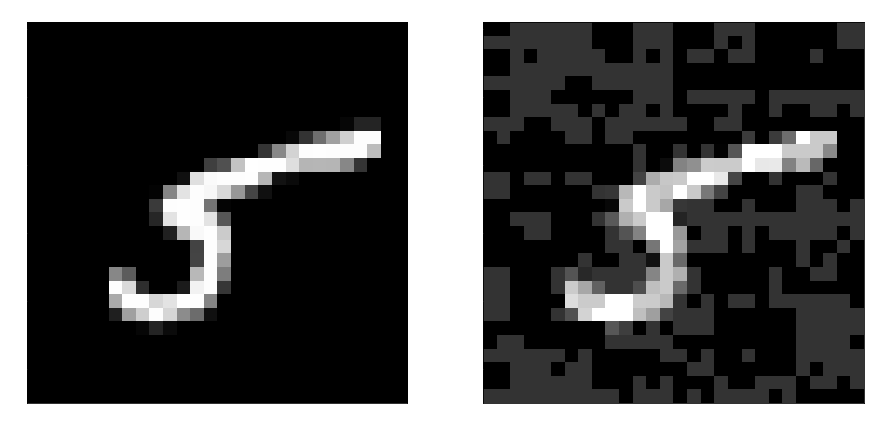

In [11]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title("Initial image")
plt.imshow(X_train[65].reshape(28, 28), cmap="gray")
print(f"Original image: {labels[np.argmax(y_train[65])]}")

plt.subplot(122)
plt.title("Adversarial image")
plt.imshow(tf.reshape(adv, (28, 28)), cmap="gray")




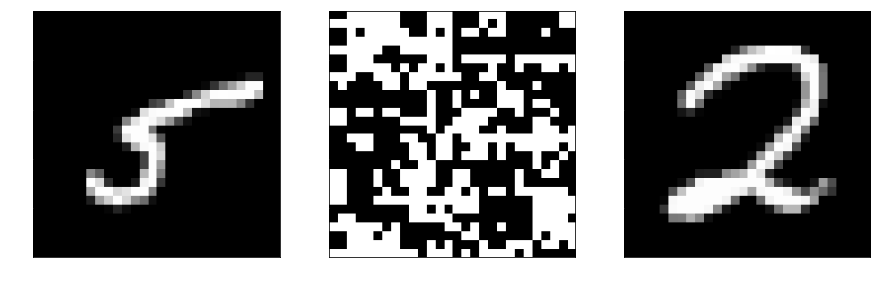

In [12]:
import cv2

plt.figure(figsize=(15, 15))

plt.subplot(131)
plt.imshow(cv2.resize(X_train[65].reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST), cmap="gray")

plt.subplot(132)
plt.imshow(cv2.resize(pert.reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST), cmap="gray")

plt.subplot(133)
plt.imshow(cv2.resize(X_test[35].reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST), cmap="gray")

plt.imsave("default_image_BIM.png", cv2.resize(X_train[65].reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST))
plt.imsave("adversarial_pertsBIM.png", cv2.resize(pert.reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST))
plt.imsave("adversarial_BIM.png", cv2.resize(np.array(adv).reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST))

In [13]:
print(f"Prediction of original network on adversarial image: {loaded_model.predict(adv).argmax()}")
print(f"Prediction of adversarial network on adversarial image: {loaded_model_adv.predict(adv).argmax()}")

Prediction of original network on adversarial image: 3
Prediction of adversarial network on adversarial image: 5


## Iterative Least-Likely Class Method - ILLCM

In [40]:
def adversarial_patternILLCM(input_image, alpha, eps, max_iter, model):
    input_image = tf.cast(input_image, tf.float32)

    prediction = model(input_image)
    Y_ll = tf.argmin(prediction, 1)

    for _ in tf.range(max_iter):

        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(input_image)
            prediction = model(input_image)
            loss = tf.keras.losses.MSE(Y_ll, prediction)

        gradient = tape.gradient(loss, input_image)

        perturbations = alpha * tf.sign(gradient)

        adv_img = input_image - perturbations
        adv_img = tf.clip_by_value(adv_img, input_image - eps, input_image + eps)
        adv_img = tf.clip_by_value(adv_img, 0, 1)

    return adv_img, Y_ll

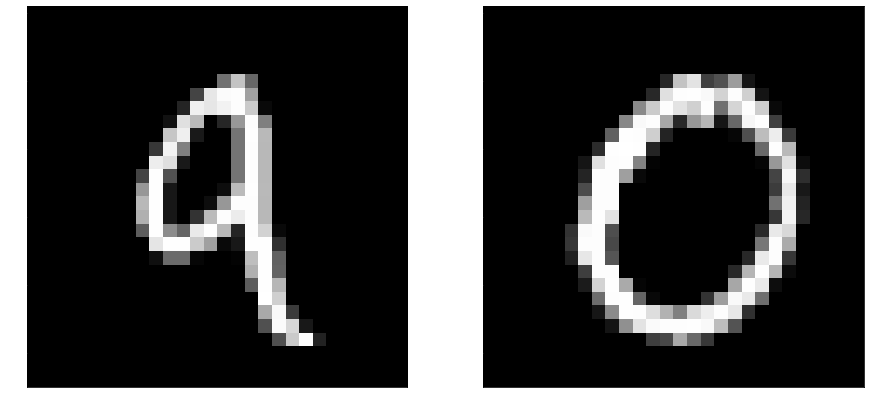

In [135]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(X_test[125].reshape(28, 28), cmap="gray")

plt.subplot(122)
plt.imshow(X_test[101].reshape(28, 28), cmap="gray")

In [141]:
image = X_test[125].reshape((1, img_cols, img_rows, channels))
adv1, Y_ll = adversarial_patternILLCM(image, 0.25*70, 0.25, 40, loaded_model)

image1 = X_test[101].reshape((1, img_cols, img_rows, channels))
adv2, Y_ll1 = adversarial_patternILLCM(image1, 4., 0.35, 50, loaded_model)

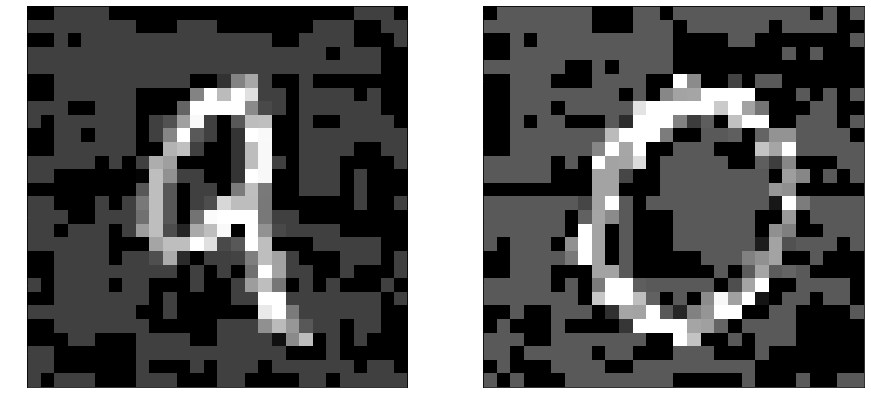

In [142]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(tf.reshape(adv1, shape=(28, 28)), cmap="gray")

plt.subplot(122)
plt.imshow(tf.reshape(adv2, shape=(28, 28)), cmap="gray")

In [137]:
print(f"Target image №1 according to ILLCM algorithm: {Y_ll}")
print(f"Target image №2 according to ILLCM algorithm: {Y_ll1}")

Target image №1 according to ILLCM algorithm: [2]
Target image №2 according to ILLCM algorithm: [3]


In [145]:
print(f"Prediction of original network on adversarial image: {loaded_model.predict(tf.reshape(adv1, (1, img_cols, img_rows, channels))).argmax()}")
print(f"Prediction of adversarial network on adversarial image: {loaded_model_adv.predict(tf.reshape(adv1, (1, img_cols, img_rows, channels))).argmax()}")

Prediction of original network on adversarial image: 2
Prediction of adversarial network on adversarial image: 8


In [96]:
print(f"Prediction of original network on adversarial image: {loaded_model.predict(tf.reshape(adv2, (1, img_cols, img_rows, channels))).argmax()}")
print(f"Prediction of adversarial network on adversarial image: {loaded_model_adv.predict(tf.reshape(adv2, (1, img_cols, img_rows, channels))).argmax()}")

Prediction of original network on adversarial image: 3
Prediction of adversarial network on adversarial image: 0


## Fast-Gradient Sign Method - FGSM

In [21]:
def adversarial_patternFGSM(image, label, model, eps):
    image = tf.cast(image, tf.float32)

    # computing loss and gradients in the next
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)

    gradient = tape.gradient(loss, image)

    # computing perturbations and creating adversarial example
    perturbations = eps * tf.sign(gradient)
    adv_img = image + perturbations

    return adv_img, perturbations

In [22]:
# image = X_test[5]
#
# plt.figure(figsize=(15, 15))
# perturb = adversarial_patternFGSM(image.reshape((1, img_rows, img_cols, channels)), y_test[5], loaded_model).numpy()
# adv_F = image + perturb*0.6
#
# plt.subplot(131)
# plt.title("Initial image")
# plt.imshow(image, cmap="gray")
#
# plt.subplot(132)
# plt.title("Adversarial image")
# plt.imshow(adv_F.reshape((img_rows, img_cols, channels)), cmap="gray")
#
# plt.subplot(133)
# plt.imshow(perturb.reshape((img_rows, img_cols, channels)), cmap="gray")

In [23]:
# plt.imsave("default_image1.png", cv2.resize(image.reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST))
# plt.imsave("adversarial11.png", cv2.resize(perturb.reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST))
# plt.imsave("adversarial22.png", cv2.resize(adv_F.reshape(28, 28), (250, 250), interpolation=cv2.INTER_NEAREST))


In [24]:
# print(f"Prediction of original network on adversarial image: {labels[loaded_model.predict(adv_F).argmax()]}")
# print(f"Prediction on original image: {labels[loaded_model.predict(image.reshape((1, img_rows, img_cols, channels))).argmax()]}")


## CIFAR experiments

Original image: airplane
Target image: truck


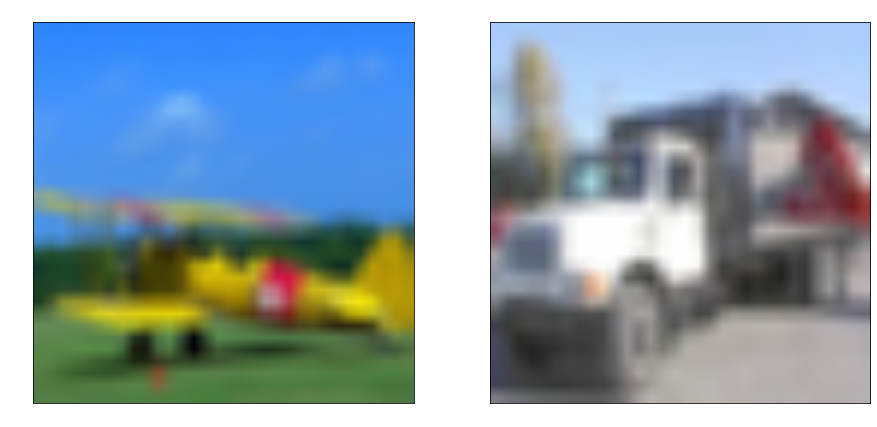

In [25]:
plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.title("Initial image")
plt.imshow(cv2.resize(X_test_C[44], (250, 250), interpolation=cv2.INTER_LINEAR))
print(f"Original image: {labels_C[np.argmax(y_test_C[44])]}")

plt.subplot(122)
plt.title("Target image")
plt.imshow(cv2.resize(X_test_C[45], (250, 250), interpolation=cv2.INTER_LINEAR))
print(f"Target image: {labels_C[np.argmax(y_test_C[45])]}")

In [26]:
image = X_test_C[44].reshape((1, img_rows_C, img_cols_C, channels_C))
true_label = y_test_C[44]

adv1, pert1 = adversarial_patternBIM(image, true_label, 0.8, 0.05, 40, loaded_model1)

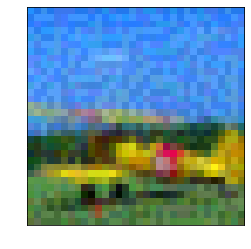

In [27]:
plt.imshow(tf.reshape(adv1, (32, 32, 3)))

In [28]:
print(f"Prediction of original network on adversarial image: {labels_C[loaded_model1.predict(adv1).argmax()]}")

Prediction of original network on adversarial image: truck


In [29]:
image_C = X_test_C[89].reshape((1, img_rows_C, img_cols_C, channels_C))

adv1_C, Y_ll_C = adversarial_patternILLCM(image_C, 0.8, 0.05, 40, loaded_model1)

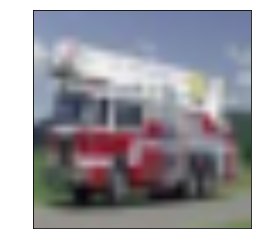

In [30]:
plt.imshow(cv2.resize(X_test_C[89], (250, 250), interpolation=cv2.INTER_LINEAR))

In [31]:
print(f"Target image №1 according to ILLCM algorithm: {labels_C[np.argmax(Y_ll_C)]}")

Target image №1 according to ILLCM algorithm: airplane


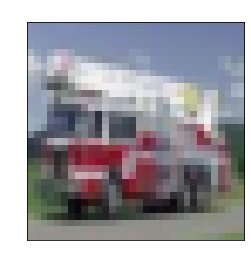

In [32]:
plt.title("Adversarial image")
plt.imshow(tf.reshape(adv1_C, (32, 32, 3)))

In [33]:
# print("{}".format([np.around(num, 4) for num in loaded_model1.predict(tf.reshape(adv1_C, (1, img_cols_C, img_rows_C, channels_C)))]))
print(f"Prediction of original network on adversarial image: {labels_C[loaded_model1.predict(tf.reshape(adv1_C, (1, img_cols_C, img_rows_C, channels_C))).argmax()]}")

Prediction of original network on adversarial image: truck


In [34]:

image_C = X_test_C[9]

plt.figure(figsize=(15, 10))
perturb1 = adversarial_patternFGSM(image_C.reshape((1, img_rows_C, img_cols_C, channels_C)), y_test_C[9], loaded_model1).numpy()
adv_FC = image_C + perturb1*0.1
image_C = image_C.copy()


plt.subplot(121)
plt.title("Initial image")
plt.imshow(cv2.resize(image_C, (250, 250), interpolation=cv2.INTER_LINEAR))

plt.subplot(122)
plt.title("Adversarial image")
plt.imshow(adv_FC.reshape((img_rows_C, img_cols_C, channels_C)))

TypeError: adversarial_patternFGSM() missing 1 required positional argument: 'eps'

<Figure size 1080x720 with 0 Axes>

In [ ]:
print(f"Prediction on adversarial image: {labels_C[loaded_model1.predict(adv_FC).argmax()]}")
# print(f"Prediction on original image: {labels_C[loaded_model1.predict(image_C.reshape((1, img_rows_C, img_cols_C, channels_C))).argmax()]}")